In [21]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import tqdm as tq

from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator

from toolbar.curved_quivers.modplot import *

def pic(fig, pic_loc, lat, lon, corr_u, corr_v, corr_z, corr_t2m, t2m):
    ax = fig.add_subplot(pic_loc, projection=ccrs.PlateCarree(180-67.5))
    ax.set_title(f'{str(picloc)[1]}) Type{str(picloc)[1]}', loc='left', fontsize=12)
    ax.set_extent([65, 165, 0, 60], crs=ccrs.PlateCarree())
    contf = ax.contourf(t2m['lon'], t2m['lat'], corr_t2m, cmap='coolwarm', levels=[-1, -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 1], extend='both')
    cont = ax.contour(lon, lat, corr_z, colors='red', levels=[-1, -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 1])
    #cont_clim = ax.contour(lon, lat, uvz_clim['z'].to_array(), colors='k', levels=5)
    Cq = Curlyquiver(ax, lon, lat, corr_u, corr_v,
                                  lon_trunc=-67.5, arrowsize=.5, scale=40, linewidth=0.4, regrid=20,
                                  transform=ccrs.PlateCarree(central_longitude=0))
    Cq.key(fig, U=1, label='1', lr=-1.1)
    ax.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.2)
    ax.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    ax.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(),
                      ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
    # 刻度线设置
    xticks1 = np.arange(60, 160, 20)
    yticks1 = np.arange(0, 60, 15)
    ax.set_yticks(yticks1, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    ymajorLocator = MultipleLocator(30)  # 先定义xmajorLocator，再进行调用
    ax.yaxis.set_major_locator(ymajorLocator)  # x轴最大刻度
    yminorLocator = MultipleLocator(10)
    ax.yaxis.set_minor_locator(yminorLocator)  # x轴最小刻度
    # ax1.axes.xaxis.set_ticklabels([]) ##隐藏刻度标签
    # 最大刻度、最小刻度的刻度线长短，粗细设置
    ax.tick_params(which='major', length=4, width=.5, color='black')  # 最大刻度长度，宽度设置，
    ax.tick_params(which='minor', length=2, width=.2, color='black')  # 最小刻度长度，宽度设置
    ax.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
    plt.rcParams['ytick.direction'] = 'out'  # 将x轴的刻度线方向设置向内或者外
    # 调整刻度值字体大小
    ax.tick_params(axis='both', labelsize=12, colors='black')

def corr(time_series, data):
        # 计算相关系数
    # 将 data 重塑为二维：时间轴为第一个维度
    shape = data.shape
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以标准化
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（标准差乘积）
    denominator = np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2))

    # 相关系数
    correlation = numerator / denominator

    # 重塑为 (lat, lon)
    correlation_map = correlation.reshape(shape[1:])
    return correlation_map


K_type = xr.open_dataset(r"D:\PyFile\p2\data\Time_type_AverFiltAll0.9%_0.3%_3.nc")

try:
    uvz = xr.open_dataset(r"D:\PyFile\p2\data\uvz_678.nc")
except:
    uvz = xr.open_dataset(r"E:\data\ERA5\ERA5_pressLev\era5_pressLev.nc").sel(
        date=slice('1961-01-01', '2023-12-31'),
        pressure_level=[200, 300, 400, 500, 600, 700, 850],
        latitude=[90 - i * 0.5 for i in range(361)], longitude=[i * 0.5 for i in range(720)])
    uvz = xr.Dataset(
            {'u': (['time', 'p', 'lat', 'lon'],uvz['u'].data),
                      'v': (['time', 'p', 'lat', 'lon'],uvz['v'].data),
                      'z': (['time', 'p', 'lat', 'lon'],uvz['z'].data)},
                     coords={'time': pd.to_datetime(uvz['date'], format="%Y%m%d"),
                             'p': uvz['pressure_level'].data,
                             'lat': uvz['latitude'].data,
                             'lon': uvz['longitude'].data})
    uvz = uvz.sel(time=slice('1961-01-01', '2022-12-31'))
    uvz = uvz.sel(time=uvz['time.month'].isin([6, 7, 8])).groupby('time.year').mean('time')
    uvz.to_netcdf(r"D:\PyFile\p2\data\uvz_678.nc")
uvz = uvz.sel(p=500).transpose('lat', 'lon', 'year')  # 500hPa
uvz_clim = uvz.mean('year')

try:
    t2m = xr.open_dataset(r"D:\PyFile\p2\data\t2m_678.nc")
except:
    t2m = xr.open_dataset(r"E:\data\ERA5\ERA5_singleLev\ERA5_sgLEv.nc")['t2m']
    t2m = t2m.sel(date=slice('1961-01-01', '2023-12-31'))
    t2m = xr.Dataset(
            {'t2m': (['time', 'lat', 'lon'],t2m.data)},
                     coords={'time': pd.to_datetime(t2m['date'], format="%Y%m%d"),
                             'lat': t2m['latitude'].data,
                             'lon': t2m['longitude'].data})
    t2m = t2m.sel(time=slice('1961-01-01', '2022-12-31'))
    t2m = t2m.sel(time=t2m['time.month'].isin([6, 7, 8])).groupby('time.year').mean('time')
    t2m.to_netcdf(r"D:\PyFile\p2\data\t2m_678.nc")
t2m = t2m.transpose('lat', 'lon', 'year')
t2m_clim = t2m.mean('year')

In [8]:
uvz['u'].transpose('year', 'lat', 'lon').data.shape

(62, 361, 720)

TypeError: Input z must be 2D, not 3D

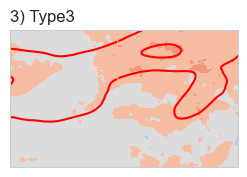

In [19]:
fig = plt.figure(figsize=(10, 5))
for i in K_type['type']:
    picloc = int(100 + len(K_type['type'])*10 + i)
    time_ser = K_type.sel(type=i)['K'].data
    corr_K_u = corr(time_ser, uvz['u'].transpose('year', 'lat', 'lon').data)
    corr_K_v = corr(time_ser, uvz['v'].transpose('year', 'lat', 'lon').data)
    corr_K_z = corr(time_ser, uvz['z'].transpose('year', 'lat', 'lon').data)
    corr_K_t2m = corr(time_ser, t2m['t2m'].transpose('year', 'lat', 'lon').data)
    pic(fig, picloc, uvz['lat'], uvz['lon'], corr_K_u, corr_K_v, corr_K_z, corr_K_t2m, t2m)
plt.show()